In [47]:
#instruction to be able to zoom on matplotlib figure
%matplotlib widget 


import sys
sys.path.insert(0,'../source')
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
from datetime import date

#from datetime import datetime

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# Import module for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, corr_data, copy_attr
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_corr_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa
from m_read_write_netcdf import corr_file

In [48]:
#
# Init.
#

# plot or no ?
info_plot = 0 # 0 : some plots are not created, 1 : all plots

# WMO Float (string format)
num_float = '6902807'
last_cycle_to_use = 231 #71 # Cycle to use to estimate a correction

# Ctd comparison to estimate a supplement gain.
cmp_ctd = 1 # 1 if we used CTD for comparison, 0 otherwise
num_cycle = np.array([1]) # Cycle to compare to CTD
rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/RREX/RREX17/']
fic_ctd = ['rr17_PRES.nc'] # Netcdf File with CTD
#rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/RREX/RREX17/']
#fic_ctd = ['rr17_PRES.nc']
num_ctd = np.array([26]) # Rapport TR : CTD 82 indiqué mais selon tracé dans rapport, c'est station 26 ....Station Number to compare

# Do we correct data from a pressure effect ?
#corr_pres_effect = 1 # 1 if we estimate a correction effect pressure, 0 otherwise
pressure_threshold = 1500  # Pressure for pressure effect estimation. We use pressure > pressure_threshold

# ARGO directory : Directory where you can find 1 directory per WMO ARGO float.
# In the WMO float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
#rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
rep_data_argo = '/Volumes/ref-argo/gdac/dac/coriolis/'

# The WOA file containing the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# this file is created by an internal LOPS routine.
#
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'

# which variable to used :
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2

#
# Which PSAT to used :
# which_psat = 1 : We use PSAT from WOA file
# which_psat = 2 We use PSAT calculated as Locodox
which_psat = 2
# Min and Max pressure to average WOA and ARGO PPOX
min_pres_interp = 0
max_pres_interp = 25

# Which QC used for pressure, temperature, salinity and oxygen.
# In Sprof, we got interpolated data (flag=8)
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

In [49]:
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/ref-argo/gdac/dac/coriolis/6902807/6902807_meta.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902807/6902807_Sprof.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902807/6902807_Rtraj.nc


In [50]:
ds_argo_Sprof = ds_argo_Sprof.where(ds_argo_Sprof['CYCLE_NUMBER']<=last_cycle_to_use,drop=True)
ds_argo_Rtraj = ds_argo_Rtraj.where(ds_argo_Rtraj['CYCLE_NUMBER']<=last_cycle_to_use,drop=True)
ds_argo_Sprof['PLATFORM_NUMBER'] = ds_argo_Sprof['PLATFORM_NUMBER'].astype(int) # The where transform the nan from int to float ...

In [51]:
if info_plot==1:
    fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
    ds_bathy = xr.open_dataset(fic_bathy)

    extend_lon_lat = 0.5
    depths = np.arange(-7000,500,500)
    plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)

In [52]:
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc)

In [53]:
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')

In [54]:
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof)

In [55]:
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')

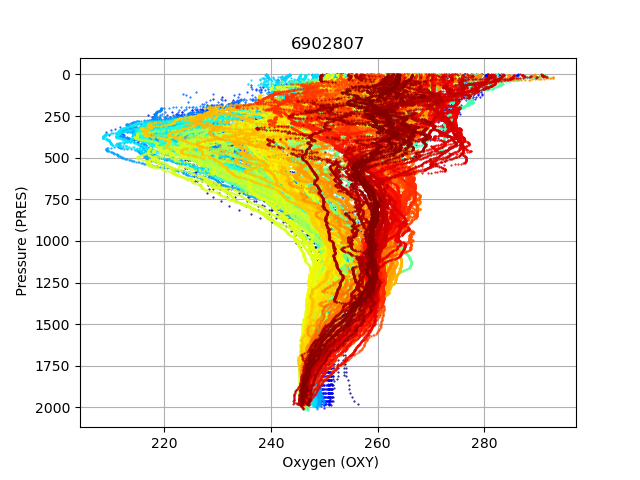

In [56]:
_=plot_DOXY_cycle(ds_argo_Sprof)

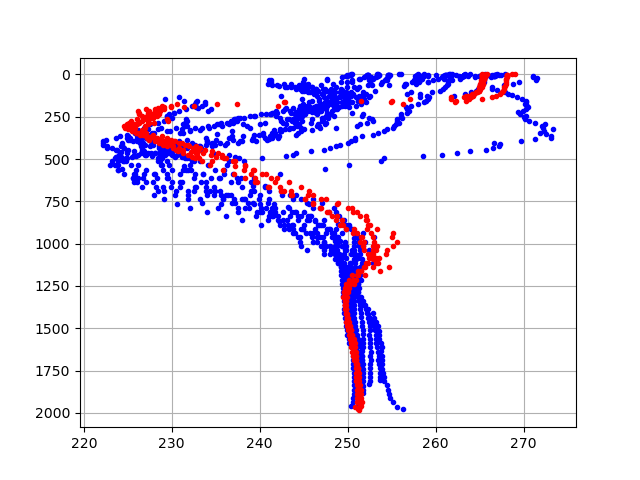

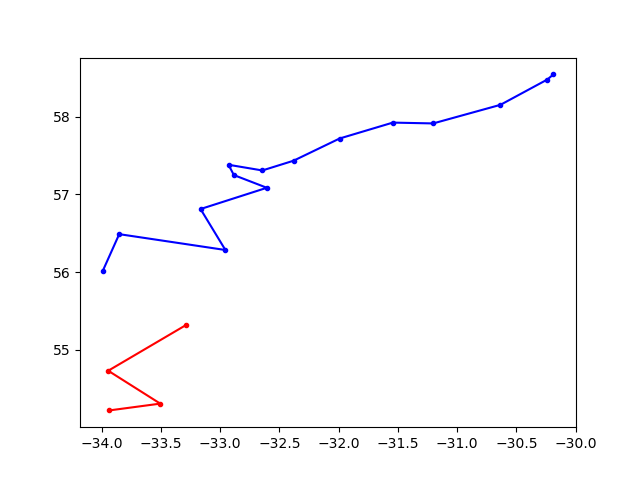

In [57]:
plt.figure()
_=plt.plot(ds_argo_Sprof['DOXY'][0:15],ds_argo_Sprof['PRES'][0:15],'.b')
_=plt.plot(ds_argo_Sprof['DOXY'][16:20],ds_argo_Sprof['PRES'][16:20],'.r')
plt.gca().invert_yaxis()
plt.grid()
plt.figure()
_=plt.plot(ds_argo_Sprof['LONGITUDE'][0:15],ds_argo_Sprof['LATITUDE'][0:15],'.-b')
_=plt.plot(ds_argo_Sprof['LONGITUDE'][16:20],ds_argo_Sprof['LATITUDE'][16:20],'.-r')


In [58]:
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2017-07-24T20:50:00.000000000
-0.291


In [59]:
delta_T_sprof = diff_time_in_days(ds_argo_Sprof['JULD'],launch_date)
print(delta_T_sprof[0:17])
print(ds_argo_Sprof['CYCLE_NUMBER'][0:17])

<xarray.DataArray 'JULD' (N_PROF: 17)>
array([1.19444444e-01, 1.38194444e+00, 1.14038194e+01, 2.14055556e+01,
       3.12802083e+01, 4.13486111e+01, 5.14003472e+01, 6.13805556e+01,
       7.14052083e+01, 8.14006944e+01, 9.13954861e+01, 1.01401389e+02,
       1.11422569e+02, 1.21402083e+02, 1.31401042e+02, 1.41384028e+02,
       1.51392014e+02])
Dimensions without coordinates: N_PROF
<xarray.DataArray 'CYCLE_NUMBER' (N_PROF: 17)>
array([ 1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])
Dimensions without coordinates: N_PROF
Attributes:
    long_name:    Float cycle number
    conventions:  0...N, 0 : launch cycle (if exists), 1 : first complete cycle
    casted:       1


In [60]:
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


In [61]:
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [62]:
ds_woa = open_WOA_file(fic_WOA)
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 15.0 46.0 75.0 106.0 ... 259.0 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 ...
    longitude  (lon) float64 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 ...
    density    (time, N_LEVELS, lat, lon) float64 ...
    preswoa    (time, N_LEVELS, lat, lon) float64 ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 ...

In [63]:
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 -15.25 15.0 46.0 75.0 ... 289.0 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    density   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
101.865898

In [64]:
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]

# Interpolation WOA et ARGO sur une grille reguliere en pression.
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [65]:
#for var in ds_argo_interp.data_vars :
#    ds_argo_interp[var].attrs = ds_argo[var].attrs    
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [66]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

We calculate PSAT as Locodox Matlab does


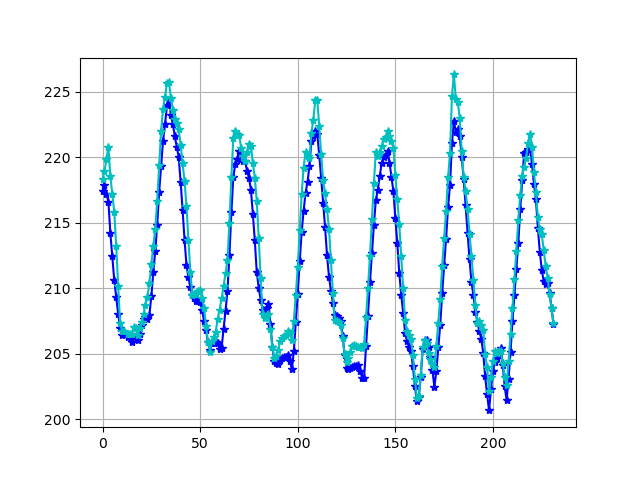

In [67]:
if which_psat == 2:
    print('We calculate PSAT as Locodox Matlab does')
    ana_dens_woa = sw.pden(ds_woa_interp['PSAL_WOA'],ds_woa_interp['TEMP_WOA'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
    O2_ARGO_umolL = umolkg_to_umolL(ds_woa_interp['doxywoa'],ds_argo['DOXY_ARGO'].units,ana_dens_woa)
    psatwoaV2 = O2ctoO2s(O2_ARGO_umolL,ds_woa_interp['TEMP_WOA'],ds_woa_interp['PSAL_WOA'])
    ppox_WOA2 = O2stoO2p(psatwoaV2,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
    ppox_WOA_mean2 = np.nanmean(ppox_WOA2,axis=1)

    plt.figure()
    plt.plot(ppox_WOA_mean,'*-b')
    plt.plot(ppox_WOA_mean2,'*-c')
    plt.grid()

    ppox_WOA_mean = ppox_WOA_mean2

In [68]:
#plt.figure()
#_=plt.plot(delta_T_WOA,np.nanmean(psatwoaV2,axis=1),'*-b')
#_=plt.plot(np.nanmean(ds_woa_interp['Psatwoa'],axis=1),'o-r')
#plt.grid()

In [69]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [70]:
# Correction : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
#params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean, ppox_WOA_mean, p0=initial_guess,nan_policy='omit')
#print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')


In [71]:
# Correction : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
#params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean, p0=initial_guess,nan_policy='omit',full_output=True)
#print(params_Gain_Derive_WOA)

initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)

In [72]:
print(params_Gain_Derive_WOA)

[1.09939333 0.10906186]


In [73]:
# NCEP Correction
# Download NCEP Data
#download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)
#annee_to_download = [min(ds_argo['JULD'].dt.year).values,max(ds_argo['JULD'].dt.year).values]
#download_NCEP_force(annee_to_download,ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


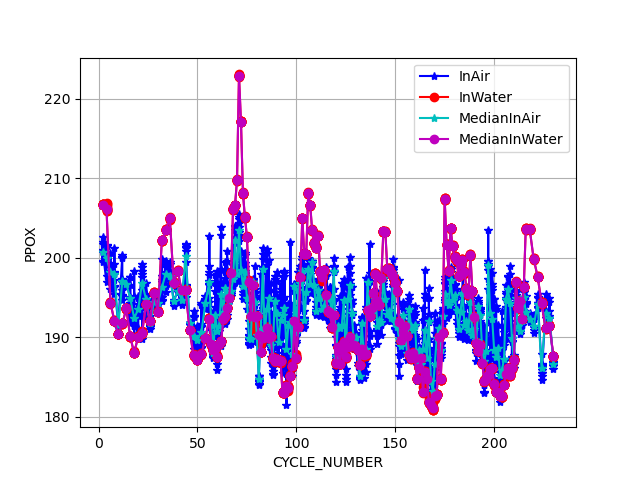

PSAL_ADJUSTED Data is used


In [74]:
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)

In [75]:
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])

z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [76]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)

In [77]:
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
params_Gain_NCEP, covariance = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit')

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [78]:
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [79]:
params_Gain_Derive_NCEP_CarryOver

array([1.06779185, 0.16295213, 0.41241597])

In [80]:
breakpoints_cycle = [1,15,ds_argo_Sprof['CYCLE_NUMBER'].values[-1]] 

G_values = []
D_values = []

#def model_CK(X, G, D, C):
    #return G * (1 + D * delta_T / (365 * 100)) * x
#    return (G / (1-C) * (1 + D / 100 * X[2]/365) * (X[0] - C * X[1]) )

initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C

breakpoints_cycle = [1,15,ds_argo_Sprof['CYCLE_NUMBER'].values[-1]] 
#breakpoints_cycle = [1,ds_argo_Sprof['CYCLE_NUMBER'].values[-1]]
for i in range(len(breakpoints_cycle) - 1):
    mask = (dsair['CYCLE_NUMBER']>=breakpoints_cycle[i]) & (dsair['CYCLE_NUMBER']<breakpoints_cycle[i+1])
    #print(dsair['CYCLE_NUMBER'].values[mask])
    var1_seg = PPOX1[mask]
    var2_seg = PPOX2[mask]
    delta_T_seg = delta_T_NCEP[mask]

    # Ajustement des paramètres G et D
    (G, C, D), _ = curve_fit(model_Gain_Derive_CarryOver, [var1_seg,var2_seg,delta_T_seg],NCEP_PPOX[mask],p0=initial_guess,nan_policy='omit')

    print(f'i vaut {i} et G et C et D : {G} - {C} - {D}')
    
    # Assurer la continuité : G doit être ajusté
    if i > 0:
        print(G_values[-1],D_values[-1],delta_T_seg[0])
        G = G_values[-1] * (1 + D_values[-1] * delta_T_seg[0] / (365 * 100)) / (1 + D * delta_T_seg[0] / (365 * 100))

    G_values.append(G)
    D_values.append(D)

print(G_values)
print(D_values)

i vaut 0 et G et C et D : 1.050937416482469 - 0.19872126647216923 - 5.877910492168686
i vaut 1 et G et C et D : 1.069140726211218 - 0.1599350860593666 - 0.38165762529613684
1.050937416482469 5.877910492168686 151.40842592592594
[1.050937416482469, 1.0748603104676393]
[5.877910492168686, 0.38165762529613684]


In [81]:
gain_Derive_CarryOver = np.array([np.array(G_values),np.array(D_values)])
print(gain_Derive_CarryOver[:,0])
print(gain_Derive_CarryOver[:,1])

[1.05093742 5.87791049]
[1.07486031 0.38165763]


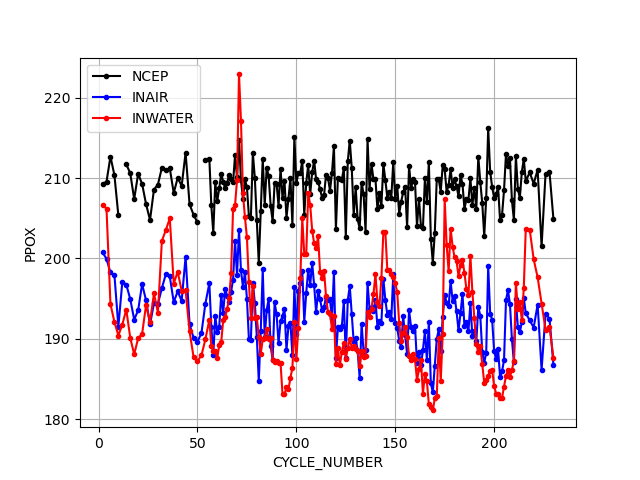

In [82]:
_ = plot_ppox_Inair_Inwater_Ncep(dsair,dsinwater,NCEP_PPOX)

In [83]:
print(params_Gain_WOA)
print(params_Gain_NCEP)
#print(params_Gain_NCEP_CarryOver[0])
print(params_Gain_Derive_WOA)
print(params_Gain_Derive_NCEP)
#print(params_Gain_Derive_NCEP_CarryOver[0],params_Gain_Derive_NCEP_CarryOver[2])
gain_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
gain_Derive_CarryOver = np.array([params_Gain_Derive_NCEP_CarryOver[0], params_Gain_Derive_NCEP_CarryOver[2]])
print(gain_CarryOver)
print(gain_Derive_CarryOver)

[1.10319013]
[1.08278975]
[1.09939333 0.10906186]
[1.06778656 0.41260663]
[1.08268171]
[1.06779185 0.41241597]


In [84]:
gain_Derive_CarryOver = np.array([G_values,D_values])
print(gain_Derive_CarryOver[:,0])
print(gain_Derive_CarryOver[:,1])
print(gain_Derive_CarryOver)

[1.05093742 5.87791049]
[1.07486031 0.38165763]
[[1.05093742 1.07486031]
 [5.87791049 0.38165763]]


ValueError: operands could not be broadcast together with shapes (2,) (195,) 

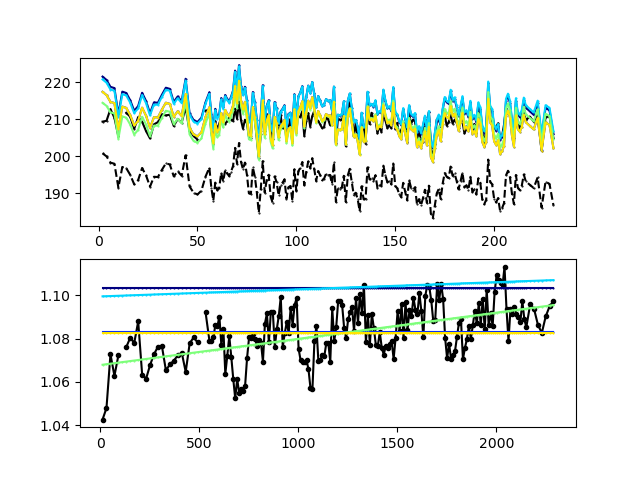

In [85]:
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : gain_CarryOver,'Gain/Derive Ncep CarryOver' : gain_Derive_CarryOver}

_=plot_cmp_corr_NCEP(dict_corr,dsair,NCEP_PPOX,delta_T_NCEP)


ValueError: operands could not be broadcast together with shapes (2,) (232,26) 

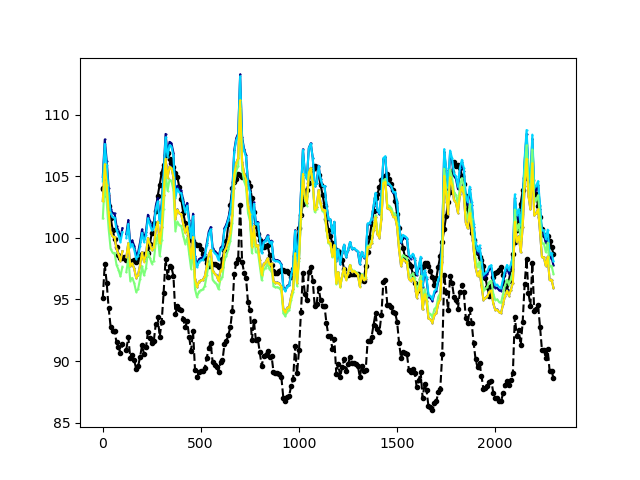

In [86]:
_=plot_cmp_corr_WOA(dict_corr, ds_argo_interp, ds_woa_interp, delta_T_WOA)

In [87]:
index = np.argmax(np.array(breakpoints_cycle) >= 15) if np.any(np.array(breakpoints_cycle) >= 15) else -1
print(breakpoints_cycle)
print(index)

[1, 15, 231.0]
1


In [88]:
print(type(gain_Derive_CarryOver))
print(type(params_Gain_Derive_NCEP))
print(gain_Derive_CarryOver.ndim)
print(params_Gain_Derive_NCEP.ndim)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
2
1


Correction : Gain and Drift : [[1.05093742 1.07486031]
 [5.87791049 0.38165763]]
[1.07486031 0.38165763]
Gain CTD : 0.9970491567472175
Pressure effect Estimation


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

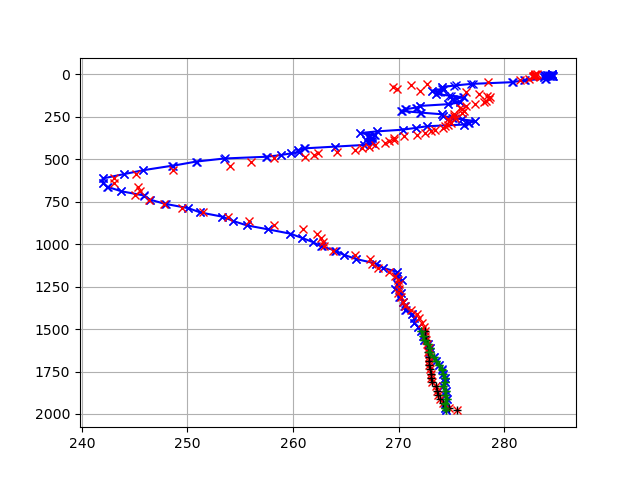

In [111]:
# Which correction to keep/apply
params_to_keep = gain_Derive_CarryOver #params_Gain_Derive_NCEP

if ( (num_float == str(6902881)) | (num_float == str(6902686)) | (num_float == str(6902978)) ): 
    params_to_keep = params_Gain_Derive_WOA
    
print(f'Correction : Gain and Drift : {params_to_keep}')

dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : gain_CarryOver,'Gain/Derive Ncep CarryOver' : gain_Derive_CarryOver}

# Init Pressure correction (0 by default) and a supplement gain form CTD (1 by default)
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])

oxy_ctd_tot = np.array([])
cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])
oxy_pour_pres_tot = np.array([])
pres_pour_pres_tot = np.array([])
cycle_pour_pres_tot = np.array([])

# Compare ARGO Profil  with  CTD 
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
       # _=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 
        
        # In Locodox, the CTD is on a regular pressure grid
        #oxy_ctd_interp1 = np.interp(np.arange(0,4010,10),ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))
        #oxy_ctd_interp = np.interp(ds_cycle['PRES'],np.arange(0,4010,10),oxy_ctd_interp1)
        oxy_ctd_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))

        oxy_ctd_tot = np.concatenate((oxy_ctd_tot,oxy_ctd_interp),axis=None)

        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))

        if len(breakpoints_cycle)>0:
            index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            index = index - 1
            params_ok = params_to_keep[:,index]
        else:
            params_ok = params_to_keep

        print(params_ok)
        
        # Information for correction for the cycle associated to the CTD
        cycle_corr = model_Gain_Derive([ds_cycle['DOXY'].isel(N_PROF=0).values,tab_delta_T],*params_ok)
        cycle_corr_tot = np.concatenate((cycle_corr_tot,cycle_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)

        # Information for pressure effect correction
        PRES_1D = ds_cycle['PRES'].squeeze()  
        mask = PRES_1D >= pressure_threshold
        pres_pour_pres_tot = np.concatenate((pres_pour_pres_tot,ds_cycle['PRES'].sel(N_LEVELS=mask)),axis=None)
        oxy_pour_pres_tot = np.concatenate((oxy_pour_pres_tot,oxy_ctd_interp[0][mask.values]),axis=None)   
        cycle_pour_pres_tot = np.concatenate((cycle_pour_pres_tot,cycle_corr[0][mask.values]),axis=None)



    plt.figure()
    _=plt.plot(oxy_ctd_tot,pres_corr_tot,'x-b')
    _=plt.plot(cycle_corr_tot,pres_corr_tot,'x-r')
    _=plt.plot(cycle_pour_pres_tot,pres_pour_pres_tot,'+-k')
    _=plt.plot(oxy_pour_pres_tot,pres_pour_pres_tot,'+-g')
    plt.gca().invert_yaxis()
    plt.grid()
    #oxy_ctd_tot = np.array(oxy_ctd_tot).flatten()
    #cycle_corr_tot = np.array(cycle_corr_tot).flatten()
    #pres_corr_tot = np.array(pres_corr_tot).flatten()
    #pres_pour_pres_tot = np.array(pres_pour_pres_tot).flatten()
    #oxy_pour_pres_tot = np.array(oxy_pour_pres_tot).flatten()
    #cycle_pour_pres_tot = np.array(cycle_pour_pres_tot).flatten()

    #print(oxy_ctd_tot.shape)
    #print(cycle_corr_tot.shape)
    #print(pres_corr_tot.shape)
    #print(cycle_pour_pres_tot.shape)
    #print(oxy_pour_pres_tot.shape)
    #print(cycle_pour_pres_tot.shape)

    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')
    print(f'Gain CTD : {params_Gain_CTD[0]}')
    # Solution with pressure effect correction
    print('Pressure effect Estimation')
    initial_guess = [0]   
    params_corr_pressure, covariance = curve_fit(model_corr_pres, [cycle_pour_pres_tot,pres_pour_pres_tot], oxy_pour_pres_tot, p0=initial_guess,nan_policy='omit') 
    cycle_corr_tot = model_corr_pres([cycle_corr_tot,pres_corr_tot],*params_corr_pressure)
    initial_guess = 0
    # CTD Gain estimation with pressure effect correction
    params_Gain_CTD_with_pressure, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')


derive_final = 0
gain_final = params_Gain_CTD[0] * params_to_keep[0]
if len(params_to_keep)==2:
    derive_final = params_to_keep[1]
corr_final_without_pressure_correction = np.array([gain_final,derive_final,params_no_corr_pressure[0]])


gain_final_with_pressure = params_Gain_CTD_with_pressure[0] * params_to_keep[0]
corr_final_with_pressure_correction = np.array([gain_final_with_pressure,derive_final,params_corr_pressure[0]])

print(f'Final Correction without pressure effect : {corr_final_without_pressure_correction}')
print(f'Final Correction with pressure effect : {corr_final_with_pressure_correction}')

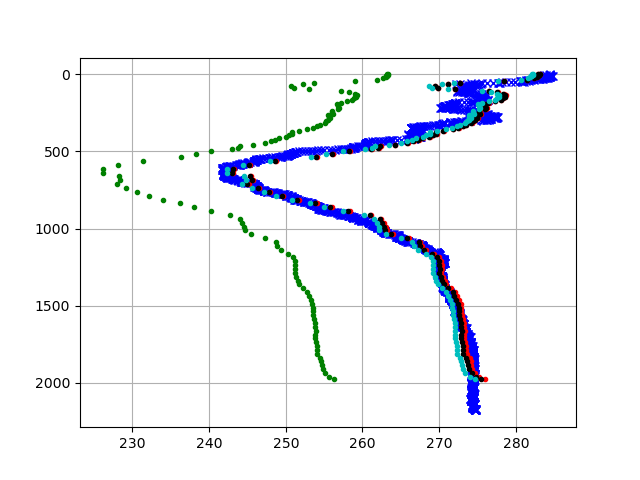

In [114]:
plt.figure()
ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==26,drop=True)
_=plt.plot(ds_cruise['OXYK'],ds_cruise['PRES'],'x-b')
ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==82,drop=True)
#_=plt.plot(ds_cruise['OXYK'],ds_cruise['PRES'],'+-r')
_=plt.plot(ds_cycle['DOXY'],ds_cycle['PRES'],'.-g')
_=plt.plot(cycle_corr_tot,pres_corr_tot,'.-r')
_=plt.plot(cycle_corr,ds_cycle['PRES'],'.-k')
_=plt.plot(cycle_corr*params_Gain_CTD[0],ds_cycle['PRES'],'.-c')


plt.gca().invert_yaxis()
plt.grid()

In [115]:
print(params_Gain_CTD[0])
print(params_to_keep)

0.9970491567472175
[[1.05093742 1.07486031]
 [5.87791049 0.38165763]]


In [92]:
# Which correction to keep/apply
params_to_keep = gain_Derive_CarryOver #params_Gain_Derive_NCEP

if ( (num_float == str(6902881)) | (num_float == str(6902686)) | (num_float == str(6902978)) ): 
    params_to_keep = params_Gain_Derive_WOA
    
print(f'Correction : Gain and Drift : {params_to_keep}')

dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : gain_CarryOver,'Gain/Derive Ncep CarryOver' : gain_Derive_CarryOver}

# Init Pressure correction (0 by default) and a supplement gain form CTD (1 by default)
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])

oxy_ctd_tot = np.array([])
cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])
oxy_pour_pres_tot = np.array([])
pres_pour_pres_tot = np.array([])
cycle_pour_pres_tot = np.array([])



# Compare ARGO Profil  with  CTD 
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        #_=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 
        

        ana_dens = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_ARGO_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens)
        ppox_cruise = O2ctoO2p(O2_ARGO_umolL,ds_cruise['TEMP'],ds_cruise['PSAL']) # On calcule PPOX pour P=0
        oxy_ctd_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        oxy_ctd_tot = np.concatenate((oxy_ctd_tot,oxy_ctd_interp),axis=None)

        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))

        # Utiliser VAR ou VAR_ADJUSTED selon which_var 
        # if which_var==1: dscycle['PSAL']=ds_cycle[‘PSAL'] elif which_var==2: ds_cycle['PSAL']=ds_cycle['PSAL_ADJUSTED'] else
        # ds_cycle['PSAL'] = ds_cycle['PSAL_ADJUSTED'].where(ds_cycle['PSAL_ADJUSTED']!=ds_cycle['PSAL_ADJUSTED'].attrs['_FillValue'],ds_cycle['PSAL'])
        # A faire pour PRES,PSAL,TEMP
        #
        ana_dens = sw.pden(ds_cycle['PSAL_ADJUSTED'],ds_cycle['TEMP_ADJUSTED'],ds_cycle['PRES_ADJUSTED'],0)
        O2_ARGO_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens)
        ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_cycle['TEMP_ADJUSTED'],ds_cycle['PSAL_ADJUSTED']) # On calcule PPOX pour P=0

        if len(breakpoints_cycle)>0:
            index = np.argmax(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) if np.any(np.array(breakpoints_cycle) >= num_cycle[i_ctd]) else -1
            index = index - 1
            params_ok = params_to_keep[:,index]
        else:
            params_ok = params_to_keep

        print(params_ok)
        
        ppox_ARGO_corr = model_Gain_Derive([ppox_ARGO,tab_delta_T],*params_ok)
        cycle_corr_tot = np.concatenate((cycle_corr_tot,ppox_ARGO_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)

   



 
    #oxy_ctd_tot = np.array(oxy_ctd_tot).flatten()
    #cycle_corr_tot = np.array(cycle_corr_tot).flatten()
    #pres_corr_tot = np.array(pres_corr_tot).flatten()
    #pres_pour_pres_tot = np.array(pres_pour_pres_tot).flatten()
    #oxy_pour_pres_tot = np.array(oxy_pour_pres_tot).flatten()
    #cycle_pour_pres_tot = np.array(cycle_pour_pres_tot).flatten()

    #print(oxy_ctd_tot.shape)
    #print(cycle_corr_tot.shape)
    #print(pres_corr_tot.shape)
    #print(cycle_pour_pres_tot.shape)
    #print(oxy_pour_pres_tot.shape)
    #print(cycle_pour_pres_tot.shape)

    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD, covariance = curve_fit(model_Gain, cycle_corr_tot, oxy_ctd_tot, p0=initial_guess,nan_policy='omit')

print(params_Gain_CTD[0])

derive_final = 0
gain_final = params_Gain_CTD[0] * params_to_keep[0]
if len(params_to_keep)==2:
    derive_final = params_to_keep[1]
corr_final_without_pressure_correction = np.array([gain_final,derive_final,params_no_corr_pressure[0]])


print(f'Final Correction without pressure effect : {corr_final_without_pressure_correction}')

Correction : Gain and Drift : [[1.05093742 1.07486031]
 [5.87791049 0.38165763]]
[1.07486031 0.38165763]
0.9959288987294611


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [143]:
#var1 = ds_cycle['DOXY'].isel(N_PROF=0).values
#var2 = ds_cycle['PRES'].isel(N_PROF=0).values
        
#valid_indices = ~np.isnan(var1)  # Indices valides où var1 n'est pas NaN

# Appliquer le masque à var1 et var2 pour ne garder que les valeurs valides
#var1_valid = var1[valid_indices]
#var2_valid = var2[valid_indices]

#gradient = np.diff(var1_valid) / np.diff(var2_valid)
#mask = np.insert(gradient > 0.2, 0, False)
#var1_valid[mask] = np.nan

In [144]:
#import scipy.io as sio


#features = sio.loadmat('/Users/chemon/ARGO_NEW/LOCODOX/git_hub/LOCODOX/sauv_var_varref.mat')
#x = features['myVar']
#y = features['myVarRef']
#initial_guess=1
#gain, covariance = curve_fit(model_Gain, x.flatten(), y.flatten(), p0=initial_guess,nan_policy='omit')
#gain

array([1.02383839])

In [149]:
#oxy_ctd_interp1 = np.interp(np.arange(0,4000,10),ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))
#oxy_ctd_interp = np.interp(ds_cycle['PRES'],np.arange(0,4000,10),oxy_ctd_interp1)
#plt.figure()
#_=plt.plot(ds_cruise['OXYK'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0),'x-b')
#_=plt.plot(oxy_ctd_interp1,np.arange(0,4000,10),'+-c')
#_=plt.plot(oxy_ctd_interp,ds_cycle['PRES'],'ok-')
#plt.gca().invert_yaxis()
#plt.grid()

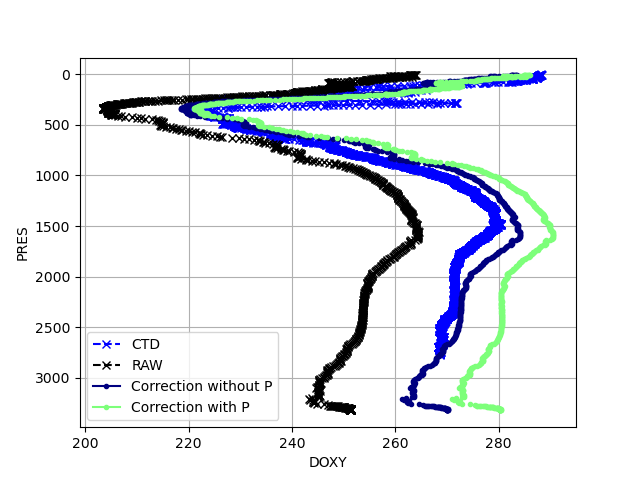

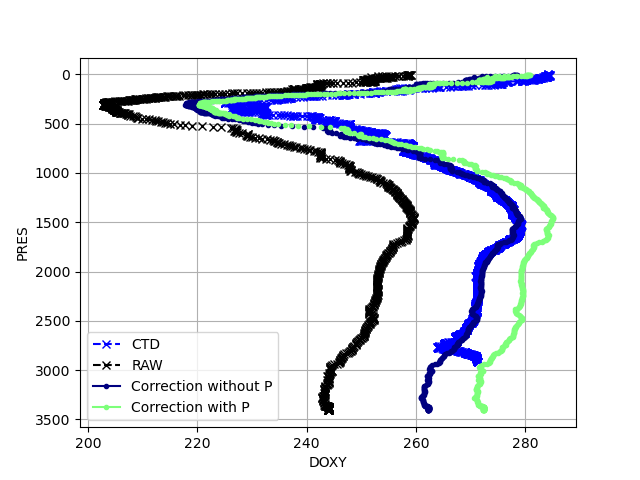

In [165]:
dict_corr = {'Correction without P' : corr_final_without_pressure_correction,'Correction with P' : corr_final_with_pressure_correction}
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        #print(ds_cruise['JULD'].values)
        #print(ds_cycle['JULD'].values)
        _=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 

In [120]:
print(params_Gain_CTD[0])
print(params_to_keep)
params_ok = params_to_keep[:,1]
gain_final = params_Gain_CTD[0] * params_ok[0]
derive_final = params_ok[1]
corr_final_without_pressure_correction = np.array([gain_final,derive_final,params_no_corr_pressure[0]])
print(corr_final_without_pressure_correction)

0.9970491567472175
[[1.05093742 1.07486031]
 [5.87791049 0.38165763]]
[1.07168857 0.38165763 0.        ]


In [121]:
corr_final = corr_final_without_pressure_correction

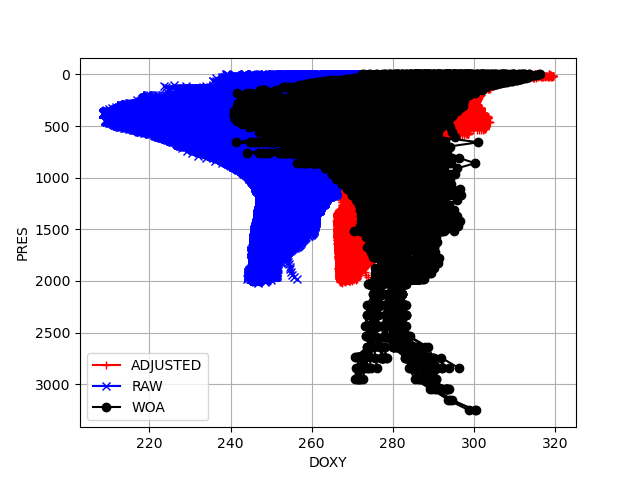

In [122]:
ds_argo_Sprof = corr_data(ds_argo_Sprof,corr_final,launch_date)
_=plot_cmp_corr_oxy_woa(ds_argo_Sprof, ds_woa_interp_on_ARGO)

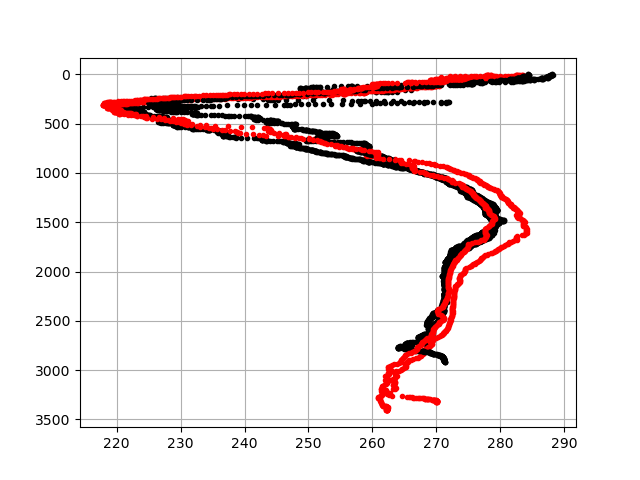

In [168]:
dict_corr = {'Correction without P' : corr_final_without_pressure_correction}
plt.figure()
for i_ctd in np.arange(len(num_ctd)):
    ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
    ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
    ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
    _=plt.plot(ds_cruise['OXYK'],ds_cruise['PRES'],'.-k')
    _=plt.plot(ds_cycle['DOXY_ADJUSTED'],ds_cycle['PRES'],'.-r')
plt.grid()
plt.gca().invert_yaxis()

In [123]:
# Correction in Sprof Dataset
date_str = date.today()
date_str = date_str.strftime("%d%m%Y")
ds_argo_final = ds_argo_Sprof[['DOXY_ADJUSTED','CYCLE_NUMBER','PRES']]
ds_argo_final.to_netcdf('/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test/corr_python_' + date_str + '_' + str(ds_argo_Sprof['PLATFORM_NUMBER'].values[0]) + '.nc')

In [38]:
#
# Gain et Derive final.
#
#gain_final = params_Gain_CTD[0] * params_Gain_Derive_NCEP[0]
#derive_final = params_Gain_Derive_NCEP[1]
coef_pres = corr_final[2]
gain_final = corr_final[0]
derive_final = corr_final[1]
val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
comment_corr = 'Adjustement made with NCEP for Gain/Drift + Gain with CTD OVIDE2018 81'
coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, COEF_PRES ={coef_pres},OFFSET=0.000000, DRIFT2=0.000000'
eq_corr = 'DOXY2 = (1 +coef_press *PRES/1000) * DOXY,DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365+DRIFT2/100.*(profile_date_juld-launch_date_juld)**2/365**2)+INCLINE_T*TEMP)*DOXY2'
#eq_corr = 'PPOX_DOXY = f(DOXY1); PPOX_DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365+DRIFT2/100.*(profile_date_juld-launch_date_juld)**2/365**2)+INCLINE_T*TEMP)*PPOX_DOXY; DOXY_ADJUSTED=f(PPOX_DOXY_ADJUSTED)'
for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    #print(fic_en_cours)
    #print(fic_res)
    if os.path.exists(fic_res):
        os.remove(fic_res)
    corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,gain_final,derive_final,coef_pres)